In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import warnings
warnings.filterwarnings("ignore")


In [84]:
df = pd.read_csv("marketing_campaign.csv")

In [86]:
# Convert 'Dt_Customer' to datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
latest_date = df['Dt_Customer'].max()

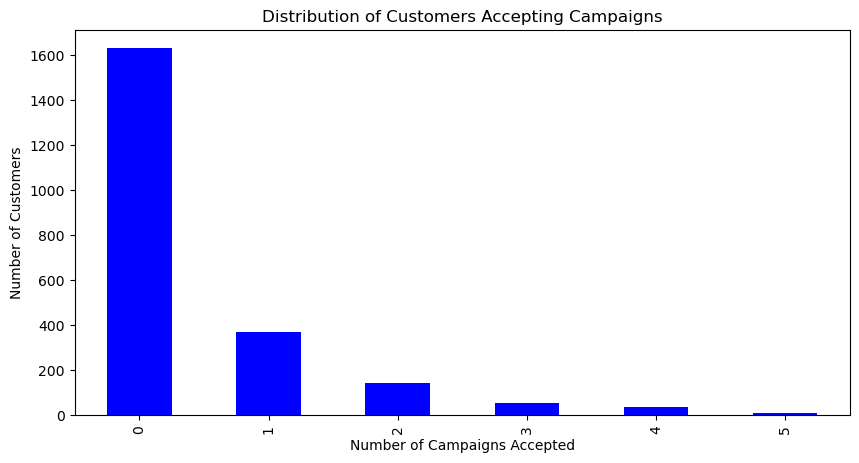

In [88]:
# Create a new column for total campaign acceptance
df["Total_Accepted"] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1)

# Plot distribution
plt.figure(figsize=(10, 5))
df["Total_Accepted"].value_counts().sort_index().plot(kind="bar", color="blue")
plt.title("Distribution of Customers Accepting Campaigns")
plt.xlabel("Number of Campaigns Accepted")
plt.ylabel("Number of Customers")
plt.show()

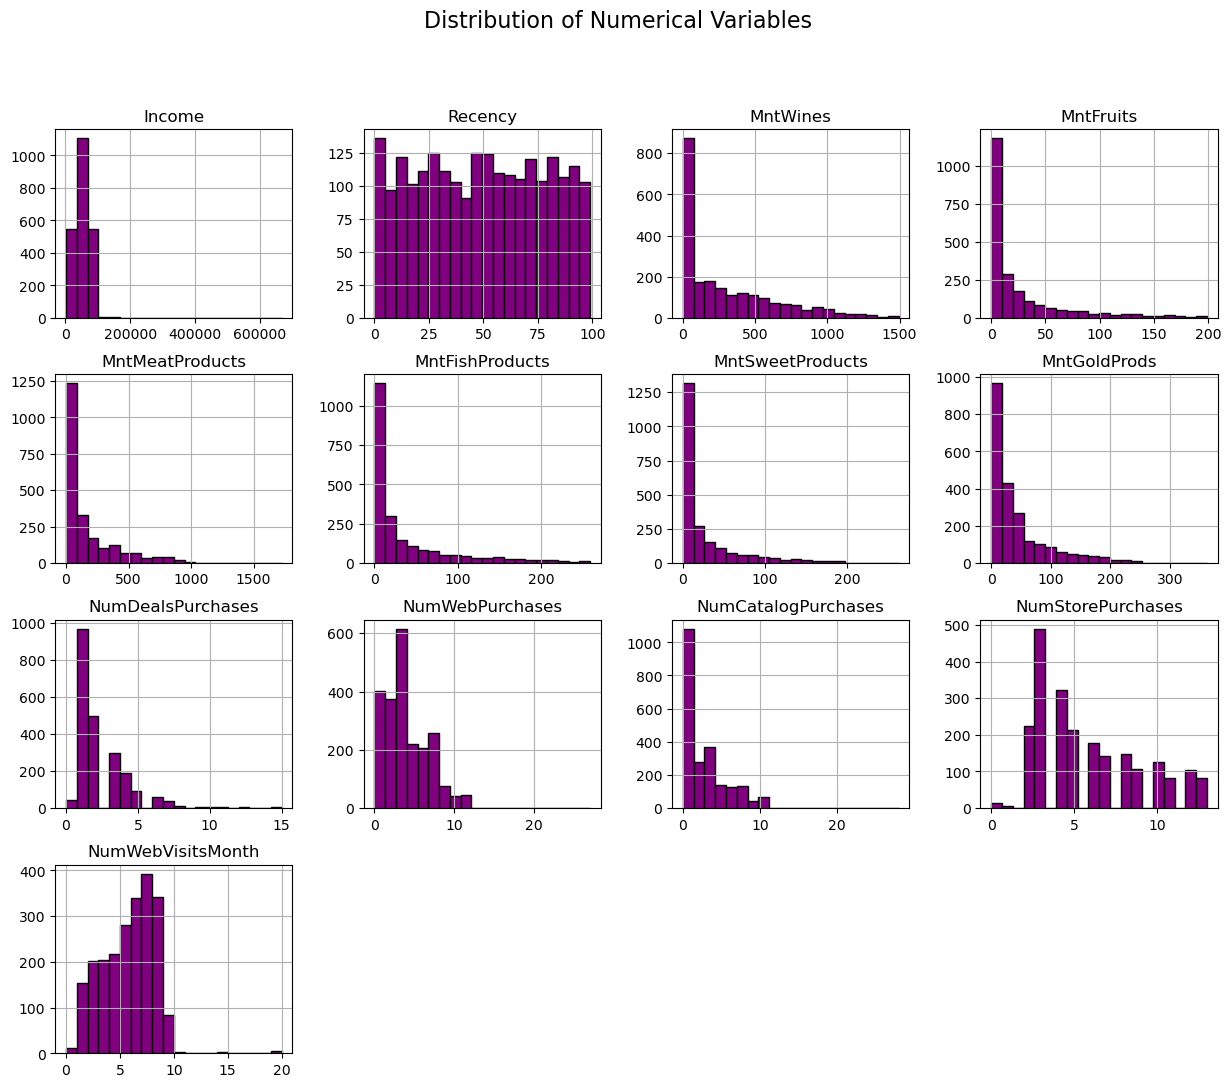

<Figure size 640x480 with 0 Axes>

In [89]:
# 2. Distribution of Numerical Variables
numerical_columns = ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 
                     'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
                     'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
df[numerical_columns].hist(figsize=(15, 12), bins=20, color="purple", edgecolor='black')
plt.suptitle("Distribution of Numerical Variables", fontsize=16)
plt.show()
plt.tight_layout()

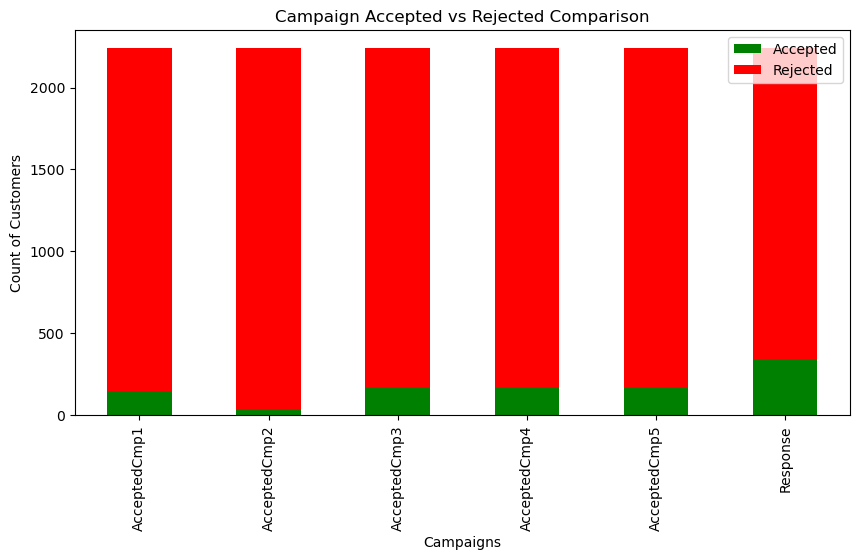

In [91]:
#Show Campaign Accepted and Rejected comparison for all the % campaigns
import seaborn as sns

# Get campaign columns
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

# Calculate accepted and rejected counts
campaign_data = pd.DataFrame({
    "Accepted": df[campaigns].sum(),
    "Rejected": len(df) - df[campaigns].sum()
})

# Plot the comparison
campaign_data.plot(kind='bar', stacked=True, figsize=(10, 5), color=["green", "red"])
plt.title("Campaign Accepted vs Rejected Comparison")
plt.xlabel("Campaigns")
plt.ylabel("Count of Customers")
plt.legend(["Accepted", "Rejected"])
plt.show()


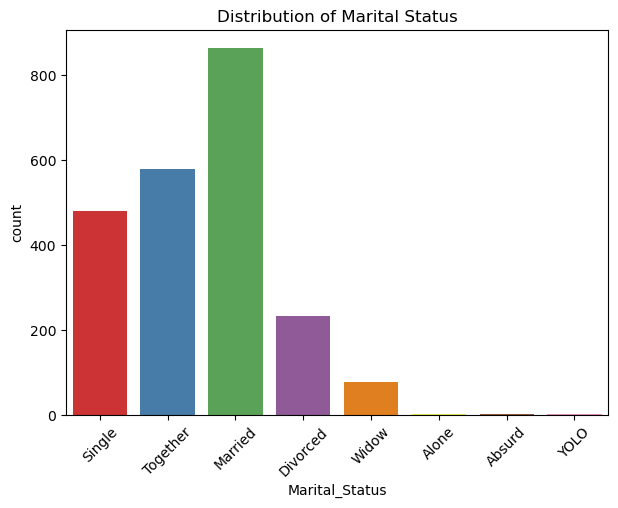

In [92]:
# Show Categorical Distribution in a Bar Chart
categorical_columns = ['Marital_Status']
plt.figure(figsize=(7, 5))
sns.countplot(x=df['Marital_Status'], palette="Set1")
plt.title("Distribution of Marital Status")
plt.xticks(rotation=45)
plt.show()

In [93]:
# Calculate RFM Metrices and make a new dataframe (Recency, Frequency and Monetary
rfm_df = df.groupby('ID').agg({
    'Dt_Customer': lambda x: (latest_date - x.max()).days,
    'ID': 'count',
    'MntWines': 'sum', 'MntFruits': 'sum', 'MntMeatProducts': 'sum', 
    'MntFishProducts': 'sum', 'MntSweetProducts': 'sum', 'MntGoldProds': 'sum'
})
rfm_df.rename(columns={'Dt_Customer': 'Recency', 'ID': 'Frequency'}, inplace=True)
rfm_df['Monetary'] = rfm_df.iloc[:, 2:].sum(axis=1)
rfm_df = rfm_df[['Recency', 'Frequency', 'Monetary']]

In [95]:
# Describe and info the Above Metrices
print(rfm_df.describe())
print(rfm_df.info())

           Recency  Frequency     Monetary
count  2240.000000     2240.0  2240.000000
mean    353.582143        1.0   605.798214
std     202.122512        0.0   602.249288
min       0.000000        1.0     5.000000
25%     180.750000        1.0    68.750000
50%     355.500000        1.0   396.000000
75%     529.000000        1.0  1045.500000
max     699.000000        1.0  2525.000000
<class 'pandas.core.frame.DataFrame'>
Index: 2240 entries, 0 to 11191
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    2240 non-null   int64
 1   Frequency  2240 non-null   int64
 2   Monetary   2240 non-null   int64
dtypes: int64(3)
memory usage: 70.0 KB
None


In [97]:
# Calculate RFM Scores
rfm_df['R'] = pd.qcut(rfm_df['Recency'], q=5, labels=[5, 4, 3, 2, 1])
rfm_df['F'] = 1
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], q=5, labels=[1, 2, 3, 4, 5])
rfm_df['R'] = rfm_df['R'].astype(int)
rfm_df['M'] = rfm_df['M'].astype(int)
rfm_df['RFM_Score'] = rfm_df['R'].astype(str) + rfm_df['M'].astype(str)
rfm_df.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score
ID,,,,,,,
0,421,1,1198,3,1,5,35
1,14,1,577,5,1,3,53
9,680,1,120,1,1,2,12
13,342,1,32,3,1,1,31
17,296,1,1028,3,1,4,34


In [99]:
#  Create RFM Segments
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}

rfm_df["Segment"] = rfm_df["RFM_Score"].replace(seg_map, regex=True)

rfm_df["Segment"].value_counts()


Segment
at_risk                377
potential_loyalists    352
loyal_customers        333
hibernating            287
cant_loose             230
about_to_sleep         188
new_customers          145
champions              143
need_attention          99
promising               86
Name: count, dtype: int64

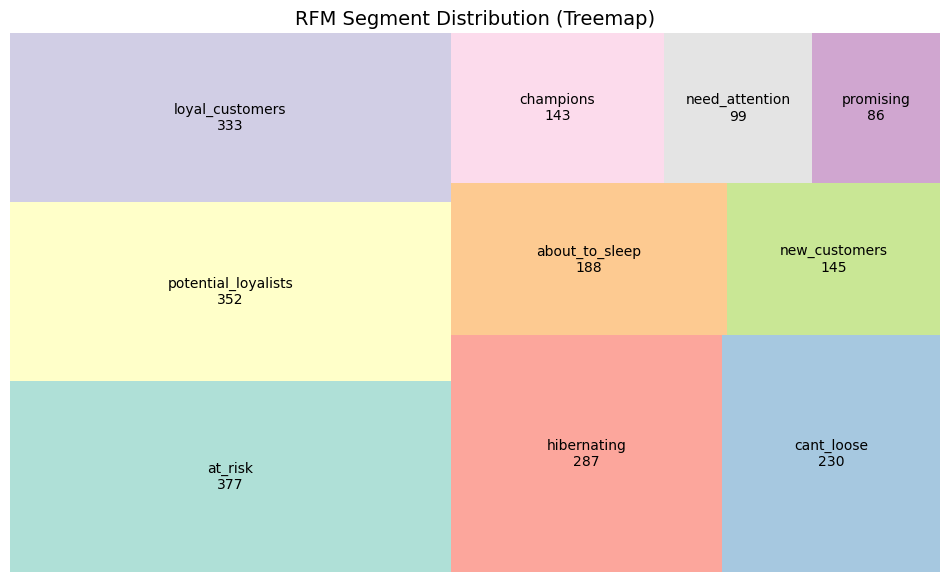

In [116]:
#  Create a Treemap Matrix for RFM Segments Distribution

# Sample data
sizes = rfm_df['Segment'].value_counts().values
labels = rfm_df['Segment'].value_counts().index
colors = sns.color_palette("Set3", len(sizes))

# Create the figure
plt.figure(figsize=(12, 7))

# Generate treemap
squarify.plot(sizes=sizes, label=[f"{l}\n{v}" for l, v in zip(labels, sizes)], alpha=0.7, color=colors)

# Title and formatting
plt.title("RFM Segment Distribution (Treemap)", fontsize=14)
plt.axis("off")

# Show the plot
plt.show()

Findings and Key Insights

1.Champions (143 customers) – Recent, frequent, and high spenders. Offer VIP programs and exclusive deals. Encourage them to refer others with incentives.

2.Loyal Customers (333 customers) – Consistent buyers. Provide personalized recommendations based on past purchases. Introduce loyalty programs to maintain engagement.

3.Potential Loyalists (352 customers) – New customers with promising behavior. Offer special discounts to encourage repeat purchases. Retarget them with personalized ads and promotions.

4.At Risk (377 customers) – Previously active but inactive now. Run reactivation campaigns with personalized offers. Collect feedback through surveys to understand inactivity.

5.Can't Lose (230 customers) – High spenders who stopped buying. Provide limited-time special offers to regain interest. Engage with personalized emails or direct communication.

6.Hibernating (287 customers) – Long inactive, low spenders. Send re-engagement emails with strong incentives. Reduce marketing efforts if there is no response.

7.New Customers (145 customers) – Recently onboarded. Offer welcome discounts and first-time purchase benefits. Guide them through an onboarding process to build engagement.